In [1]:
using SparseArrays, LinearAlgebra, ArnoldiMethod
using LsqFit
using LaTeXStrings
using Plots
using Statistics
using ProgressMeter

id = [1 0; 0 1] |> sparse
sx = [0 1; 1 0] |> sparse
sz = [1 0; 0 -1] |> sparse;

In [2]:
function build_HA(ns, Szi, A=50; bar=false)
    N = 4 + 3*(ns - 1)
    
    Abar = 0
    Bbar = 0
    
    Heff = zeros(N+1, N+1)
    
    IdN = sparse(1.0I, 2^N, 2^N)

    Hs = A/4 * (2*IdN + 2*Szi[1]*Szi[ns+1])
    Ht = A/4 * (2*IdN + 2*Szi[N]*Szi[2*ns+1])
    
    Heff[2, ns+2] += 2
    Heff[2*ns+2, N+1] += 2
    
    Abar += 6/N - 2
    
    Hij = spzeros(Int, 2^N, 2^N)
    
    # source and tagert horizontal edges
    Hij += IdN - Szi[1]*(Szi[2] + Szi[ns+2]) - 2*Szi[1]
    Hij += IdN - Szi[N]*(Szi[2*ns] + Szi[N-1]) - 2*Szi[N]
    
    Heff[2, 3] += -1
    Heff[2, ns+3] += -1
    Heff[1, 2] += -2
    
    Heff[2*ns+1, N+1] += -1
    Heff[N, N+1] += -1
    Heff[1, N+1] += -2

    # horizontal corner edges
    Hij += 2*IdN + Szi[ns]*(Szi[2*ns] - Szi[ns-1] - Szi[2*ns+1]) + 2*Szi[ns]
    Hij += 2*IdN + Szi[2*ns+2]*(Szi[ns+2] - Szi[2*ns+3] - Szi[ns+1]) + 2*Szi[2*ns+2]
    
    Heff[ns+1, 2*ns+1] += 1
    Heff[ns, ns+1] += -1
    Heff[ns+1, 2*ns+2] += -1
    Heff[1, ns+1] += 2
    
    Heff[ns+3, 2*ns+3] += 1
    Heff[2*ns+3, 2*ns+4] += -1
    Heff[ns+2, 2*ns+3] += -1
    Heff[1, 2*ns+3] += 2
    
    # vertical corner edges
    Hij += IdN - Szi[ns+1]*Szi[2*ns+2]
    Hij += IdN - Szi[2*ns+1]*Szi[ns]
    
    Heff[ns+2, 2*ns+3] += -1
    Heff[ns+1, 2*ns+2] += -1
    
    Abar += -8/N - 8
    Bbar = 0
    
    # lower horizontal internal edges
    for i in 2:ns-1
        Hij += 2*IdN + Szi[i]*(Szi[i+ns] - Szi[i-1] - Szi[i+ns+1] - Szi[i+1])
        
        Abar += -2
        
        Heff[i+1, i+1+ns] += 1
        Heff[i, i+1] += -1
        Heff[i+1, i+ns+2] += -1
        Heff[i+1, i+2] += -1
    end
    # vertical internal edges
    for i in ns+2:2*ns
        Hij += 4*IdN + Szi[i]*(Szi[i-ns] + Szi[i+ns] - Szi[i-ns-1] - Szi[i+ns+1]) + 4*Szi[i]
        
        Abar += 4/N - 4
        Bbar += 4
        
        Heff[i+1-ns, i+1] += 1
        Heff[i+1, i+1+ns] += 1
        Heff[i-ns, i+1] += -1
        Heff[i+1, i+ns+2] += -1
        Heff[1, i+1] += 4
    end
    # higher horizontal internal edges
    for i in 2*ns+3:N-1
        Hij += 2*IdN + Szi[i]*(Szi[i-ns] - Szi[i-1] - Szi[i-ns-1] - Szi[i+1])
        
        Abar += -2
        
        Heff[i+1-ns, i+1] += 1
        Heff[i, i+1] += -1
        Heff[i-ns, i+1] += -1
        Heff[i+1, i+2] += -1
    end

    Abar = A/4 * Abar
    Bbar = A/4 * Bbar
    
    Heff = A/4 * Heff
    Heff = Heff .+ transpose(Heff)
    
    Hij = A/4 * Hij
    HA = Hs + Ht + Hij
    
    if bar
        return HA, Heff, Abar, Bbar
    end

    HA, Heff
end


function build_HB(ns, Szi, W, B=1)
    N = 4 + 3*(ns - 1)
    
    IdN = sparse(1.0I, 2^N, 2^N)

    HB = B / 2 * sum(W) * IdN
    for i in 1:N
        HB += B / 2 * W[i] * Szi[i]
    end

    HB
end


function build_Hx(ns)
    N = 4 + 3*(ns - 1)
    
    # vector of operators: [sx, id, ...]
    Sx_list = fill(id, N)
    Sx_list[1] = sx

    HX = spzeros(Int, 2^N, 2^N)
    for i in 1:N
        HX -= foldl(kron, Sx_list)
        Sx_list = circshift(Sx_list, 1)
    end
    HX
end


function eigs(x; nev=2)
    decomp, history = partialschur(x, nev=nev, which=SR())
    e, v = partialeigen(decomp)
    e, v
end;

In [3]:
ns = 1
N = 4

A = 50
B = 1

IdN = sparse(1.0I, 2^N, 2^N)
    
# vector of operators: [sz, id, id, ...]
Sz_list = fill(id, N)
Sz_list[1] = sz

Szi = fill(IdN, N)
for i in 1:N
    Szi[i] = foldl(kron, Sz_list)
    # cyclic shift the operators
    Sz_list = circshift(Sz_list, 1)
end

Hs = A/4 * (2*IdN + 2*Szi[1]*Szi[2])
Ht = A/4 * (2*IdN + 2*Szi[3]*Szi[4])

Hij = A/4 * (2*IdN - 2*Szi[1]*Szi[3])
Hij += A/4 * (2*IdN - 2*Szi[2]*Szi[4])

HA1 = Hs + Ht + Hij

Heff1 = zeros(N+1, N+1)
Heff1[2, 3] = A/2
Heff1[4, 5] = A/2
Heff1[2, 4] = -A/2
Heff1[3, 5] = -A/2

Heff1 = Heff1 + transpose(Heff1);

In [4]:
n = 301
S = LinRange(0, 0.15, n)

ns = 3
N = 4 + 3*(ns - 1)

IdN = sparse(1.0I, 2^N, 2^N)

# vector of operators: [sz, id, id, ...]
Sz_list = fill(id, N)
Sz_list[1] = sz

Szi = fill(IdN, N)
for i in 1:N
    Szi[i] = foldl(kron, Sz_list)
    # cyclic shift the operators
    Sz_list = circshift(Sz_list, 1)
end

if ns != 1
    HA, Heff, Abar, Bbar = build_HA(ns, Szi, bar=true, A)
else
    HA = copy(HA1)
    Heff = copy(Heff1)
end

W = rand(N)
HB = build_HB(ns, Szi, W, B)
Hp = HA + HB

Hx = build_Hx(ns)

for (i, w) in enumerate(W)
    Heff[1, i+1] += B*w/2
    Heff[i+1, 1] += B*w/2
end

K = Heff[1, 2:end]

E = zeros(n, 2)
Eeff = zeros(n, 2)
for (i, s) in enumerate(S)
    H = (1-s)*Hx + s*Hp
    E[i, :] = eigs(H)[1]
    
    Heff_s = s*Heff .+ 2*(1-s)*I(N+1)
    Heff_s[1, 1] = 0
    
    Eeff[i, :] = real.(eigvals(Heff_s)[1:2])
end

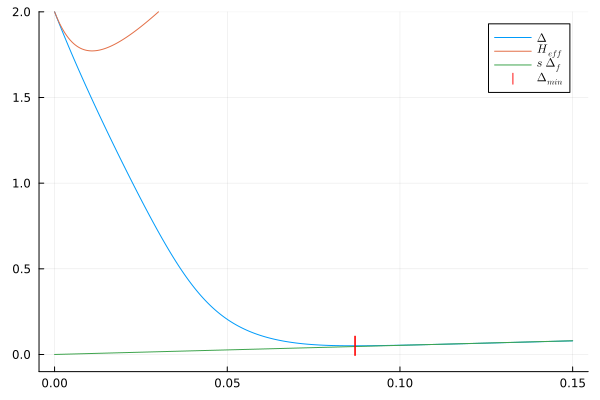

In [5]:
DE = E[:, 2] - E[:, 1]
plot(S, DE, label=L"\Delta", ylims=[-.1, 2])
plot!(S, Eeff[:, 2] - Eeff[:, 1], label=L"H_{eff}")

Ef = eigs(Hp)[1]
Df = Ef[2] - Ef[1];
plot!(S, Df*S, label=L"s\ \Delta_f")

plot!([S[argmin(DE)]], [minimum(DE)], seriestype=:scatter, label=L"\Delta_{min}", 
      marker=:vline, markersize=10, markerstrokewidth=2, color=:red)

In [6]:
E , V = eigen(Heff[2:end, 2:end])
E = round.(E, digits=3)
d = size(E[abs.(E .- E[1]) .== 0])[1] + 1

K = Heff[1, 2:end]

Hd = zeros(d+1, d+1)
Hd2 = zeros(d, d)
for i in 1:d
    Hd[1, i+1] = sum(K .* V[:, i])
    Hd[i+1, 1] = sum(K .* V[:, i])
    Hd[i+1, i+1] = E[i]
end

E = zeros(n, 2)
Eeff = zeros(n, 2)
for (i, s) in enumerate(S)
    H = (1-s)*Hx + s*Hp
    E[i, :] = eigs(H)[1]
    
    Heffs = s*Hd .+ 2*(1-s)*I(d+1)
    Heffs[1, 1] = 0
    Eeff[i, :] = eigvals(Heffs)[1:2]
end

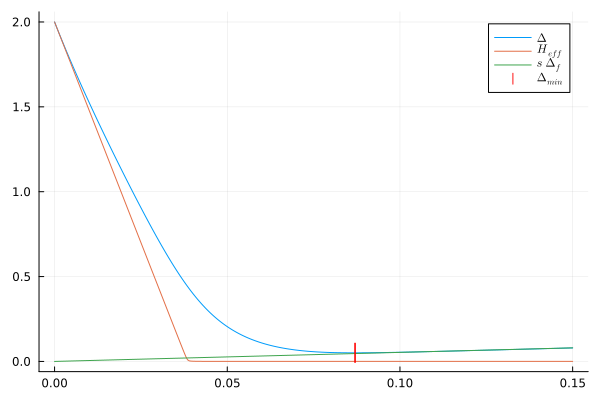

In [7]:
DE = E[:, 2] - E[:, 1]
plot(S, DE, label=L"\Delta")

plot!(S, Eeff[:, 2] - Eeff[:, 1], label=L"H_{eff}")
plot!(S, Df*S, label=L"s\ \Delta_f")
plot!([S[argmin(DE)]], [minimum(DE)], seriestype=:scatter, label=L"\Delta_{min}", 
      marker=:vline, markersize=10, markerstrokewidth=2, color=:red)

In [8]:
minimum(DE) / minimum(Eeff[:, 2] - Eeff[:, 1]) 

258.28747250612395